### Import Library ###

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

## 5.1 Data preparation ##

In [92]:
filenames = glob.glob('./assets/face_mini/**/*.jpg')

In [93]:
len(filenames)

3203

In [71]:

target_size = (80,80)
all_imgs = []
for i, file in enumerate(filenames):
  img = image.load_img(file, target_size=target_size, interpolation="nearest")

  img = image.img_to_array(img)

  img = img / 255

  all_imgs.append(img)

all_imgs = np.array(all_imgs)

In [72]:
all_imgs.shape

(3203, 80, 80, 3)

In [73]:
x_train, x_test = train_test_split(all_imgs, random_state=32, test_size=0.3)
x_train, x_val = train_test_split(x_train, random_state=32, test_size=0.3)

In [74]:
x_train.shape, x_test.shape, x_val.shape

((1569, 80, 80, 3), (961, 80, 80, 3), (673, 80, 80, 3))

## 5.2 Adding Noise ##

In [75]:
"""
• # Add Noise
  • ก ําหนด noise factor (noise level)
    • # Add noise
      • noise_factor = scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
"""
noise_factor = 0.5


In [76]:
"""
• # ก ําหนด noise parameter
  • Noise distribution: normal
  • Noise mean: zero mean (Nmean = 0)
  • Noise std: unit variance (Nstd = 1)
"""
Nmean = 0
Nstd = 1


In [77]:
"""
• # use np.random.normal to generate normal distribution (gaussian) noise
  • x_train_noisy = x_train + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_train.shape))
  • x_val_noisy = x_val + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_val.shape))
  • x_test_noisy = x_test + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_val.shape))
"""

x_train_noisy = x_train + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_train.shape))
x_val_noisy = x_val + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_val.shape))
x_test_noisy = x_test + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_test.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


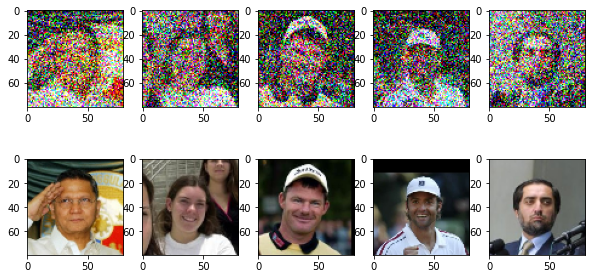

In [78]:
row, col = 2, 5
plt.figure(figsize=(10,5))
image_dic = { 0:x_val_noisy, 1:x_val}
for i in range(row):
  for j in range(col):
    plt.subplot(row, col, i*col + j + 1)
    plt.imshow(image_dic[i][j])

## 5.3 Autoencoder ##

In [79]:
# ก ําหนด Encoder Architecture
Input_img = Input(shape=x_train[0].shape)
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

In [80]:
# ก ําหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
decoded = Conv2D(3, (3, 3), padding='same')(x5)

In [81]:
# ก ําหนด optimizer setting
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 256)       7168      
                                                                 
 conv2d_15 (Conv2D)          (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 40, 64)        73792     
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 64)        36928     
                                                           

In [98]:
epochs = 4 # [2,3,4]
batch_size = 32 # [8,16,32]
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [99]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= epochs, batch_size = batch_size, shuffle = True, validation_data = (x_val_noisy, x_val), callbacks = [early_stopper])

Epoch 1/4
50/50 [==============================] - 323s 6s/step - loss: 0.0081 - val_loss: 0.0079
Epoch 2/4
50/50 [==============================] - 313s 6s/step - loss: 0.0076 - val_loss: 0.0078
Epoch 3/4
50/50 [==============================] - 310s 6s/step - loss: 0.0075 - val_loss: 0.0077
Epoch 4/4
50/50 [==============================] - 318s 6s/step - loss: 0.0074 - val_loss: 0.0075


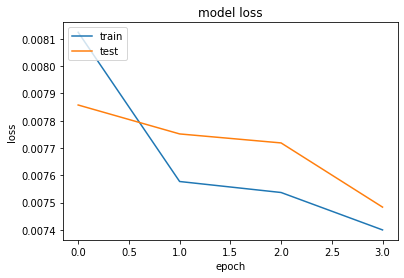

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [104]:
predictions = autoencoder.predict(x_val_noisy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


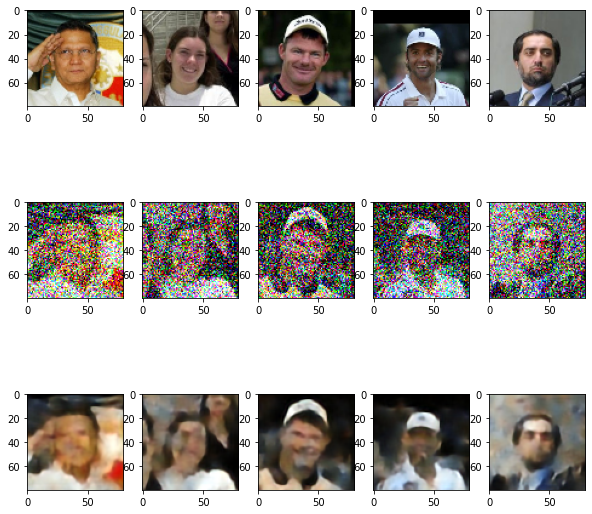

In [105]:
row, col = 3, 5
image_dic = { 0:x_val, 1:x_val_noisy, 2:predictions}
plt.figure(figsize=(10,10))

for i in range(row):
  for j in range(col):
    plt.subplot(row, col, i*col + j + 1)
    plt.imshow(image_dic[i][j])

In [106]:
predictions = autoencoder.predict(x_test_noisy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

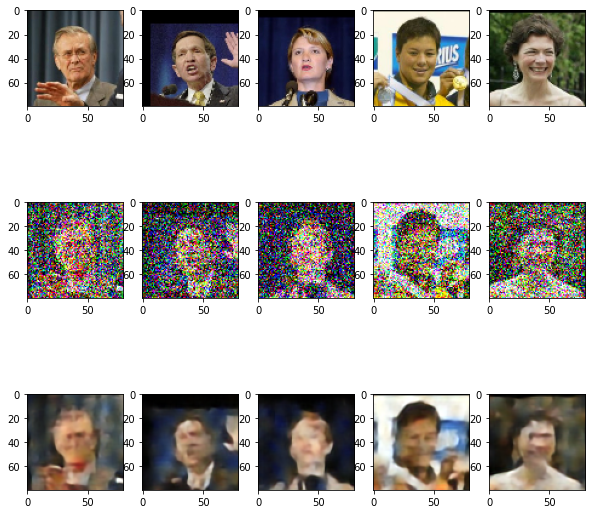

In [107]:
row, col = 3, 5
image_dic = { 0:x_test, 1:x_test_noisy, 2:predictions}
plt.figure(figsize=(10,10))

for i in range(row):
  for j in range(col):
    plt.subplot(row, col, i*col + j + 1)
    plt.imshow(image_dic[i][j])